In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
IMG_SIZE = (64,64)
BATCH_SIZE = 32
DATA_DIR = "../data"

train_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 2121 files belonging to 2 classes.
Found 722 files belonging to 2 classes.
Found 363 files belonging to 2 classes.


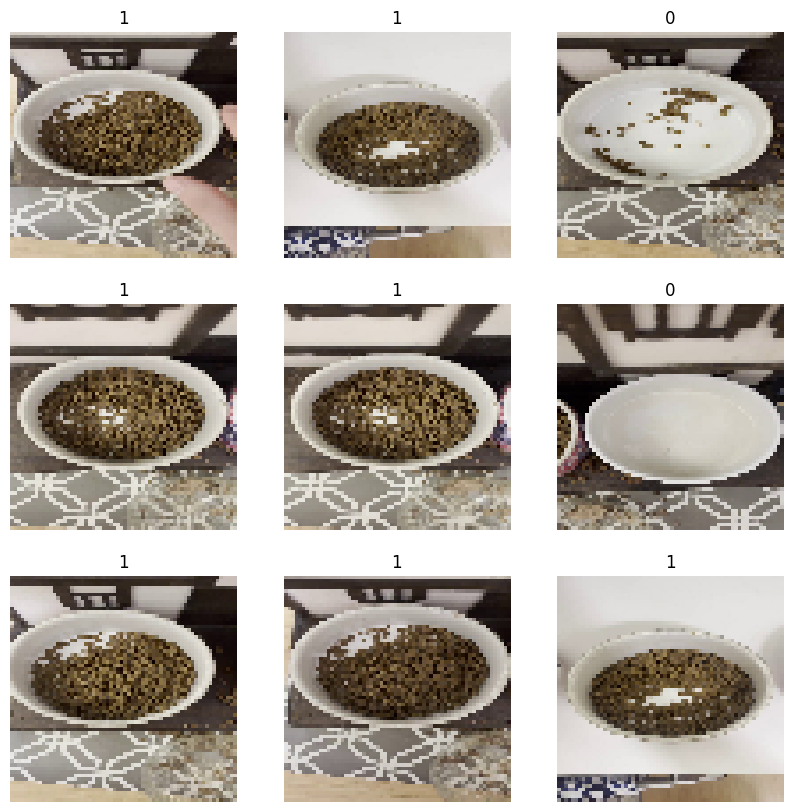

In [3]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 10))

for i in range(9):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy()))
    plt.axis("off")

plt.show()

In [4]:
IMG_SIZE = 32

model = keras.Sequential([
    keras.layers.Rescaling(1/255.0, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


C:\Users\silva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6209 - loss: 0.6622 - val_accuracy: 0.6343 - val_loss: 0.6723
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7610 - loss: 0.5478 - val_accuracy: 0.9945 - val_loss: 0.3646
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9557 - loss: 0.2148 - val_accuracy: 1.0000 - val_loss: 0.0833
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.0445 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - v

In [6]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0013


[0.0013420302420854568, 1.0]

In [8]:
model.export("saved_model")

# Convert to .tflite (float)
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("catbowl3.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved catbowl.tflite")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1475256163152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256167760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256167376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256167568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256167952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256171792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256171600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256172176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256163344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1475256162960: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved catbowl.tflite
